In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from control import ctrb, obsv
from scipy.linalg import sqrtm
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid
import scipy.linalg
from math import sqrt
import time
from scipy.special import gamma
from IPython.display import display, clear_output

In [336]:
# Равномерное сэмплирование в гиперсфере (через него равномерно генерируем в гиперэллипсоиде)
def random_ball(dimension):
    
    direction = np.random.normal(size=(dimension, ))
    direction /= np.linalg.norm(direction)
    r = np.random.random() ** (1 / dimension)
    return direction * r


# Равномерное сэмплирование в гиперэллипсоиде
def random_ellipsoid(dimension, center, matrix, obstacles):
   
    L = np.linalg.cholesky(matrix)
    x_ball = random_ball(dimension)
    x_ellipse = L @ x_ball + center
    while not ObstacleFree(obstacles, x_ellipse):
        x_ball = random_ball(dimension)
        x_ellipse = L @ x_ball + center
        
    return x_ellipse

In [577]:
# Равномерное сэмплирование в гиперкубе (наше ограниченное пространство), для базового алгоритма
def random_hypercube(dimension, center, side, obstacles):
    sample = center + np.random.random(dimension) * side
    while not ObstacleFree(obstacles, sample):
        sample = center + np.random.random(dimension) * side
    return sample

In [3]:
# Ввод пользователем параметров решаемой задачи
def UserInput():
    
    n = 2
    m = 2
    A = np.array([[1, 0], [0, 1]])
    B = np.array([[1, 2], [0, 1]])
    C = np.array([[0], [0]])
    R = np.array([[1, 0], [0, 1]])
    Q = np.array([[2, 1], [1, 2]])
    S = np.array([[2, 1], [1, 2]])
    x0 = np.array([[1], [1]])
    #xT = np.array([[2], [2]])
    t0 = 0
    T_max = 1
    count = 1001
    #T_grid_size = 101
    
    #n = int(input('Размерность вектора состояния\n'))
    #m = int(input('Размерность вектора управления\n'))
    
    #A = np.array([list(map(float, input(f'Введите {i} строку матрицы A\n').split())) for i in range(n)])
    if not A.shape == (n, n):
        print('Ошибка при вводе матрицы A')
        return False

    #B = np.array([list(map(float, input(f'Введите {i} строку матрицы B\n').split())) for i in range(n)])
    if not B.shape == (n, m):
        print('Ошибка при вводе матрицы B')
        return False

    if not np.linalg.matrix_rank(ctrb(A, B)) == n:
        print('Ошибка, (A, B) - неуправляема')
        return False         
        
    #C = np.array([list(map(float, input(f'Введите {i} строку матрицы C\n').split())) for i in range(n)])
    if not C.shape == (n, 1):
        print('Ошибка при вводе матрицы C')
        return False
    else: 
        C = C.reshape(n, )

    #R = np.array([list(map(float, input(f'Введите {i} строку матрицы R\n').split())) for i in range(m)])
    if not (R.shape == (m, m) and np.all(R == R.T) and np.all(np.linalg.eig(R)[0] > 0)):
        print('Ошибка при вводе матрицы R')
        return False
    
    #Q = np.array([list(map(float, input(f'Введите {i} строку матрицы Q\n').split())) for i in range(n)])
    if not (Q.shape == (n, n) and np.all(Q == Q.T) and np.all(np.linalg.eig(Q)[0] >= 0)):
        print('Ошибка при вводе матрицы Q')
        return False
    
    if not np.linalg.matrix_rank(obsv(A, sqrtm(Q))) == n:
        print('Ошибка, (A, Q^{1/2}) - ненаблюдаема')
        return False 
    
    #S = np.array([list(map(float, input(f'Введите {i} строку матрицы S\n').split())) for i in range(n)])
    if not (S.shape == (n, n) and np.all(S == S.T) and np.all(np.linalg.eig(S)[0] >= 0)):
        print('Ошибка при вводе матрицы S')
        return False
    
    #x0 = np.array([list(map(float, input(f'Введите {i} строку вектора начального состояния x0\n').split())) \
    #               for i in range(n)])
    if not x0.shape == (n, 1):
        print('Ошибка при вводе x0')
        return False    
    else: 
        x0 = x0.reshape(n, )
        
    #xT = np.array([list(map(float, input(f'Введите {i} строку вектора конечного состояния xT\n').split())) \
    #               for i in range(n)])
    if not xT.shape == (n, 1):
        print('Ошибка при вводе xT')
        return False 
    else: 
        xT = xT.reshape(n, ) 
        
    #t0 = float(input('Введите начальный момент времени\n')) 
    #T_max = float(input('Введите ограничение на время построения траектории (соотв рассм мн-ву дост-ти)\n')) 
    #count = int(input('Введите число точек разбиения временного отрезка\n'))
    #T_grid_size = int(input('Введите размер сетки перебора конечных моментов времени\n'))
    
    return A, B, C, R, Q, S, x0, xT, t0, T_max, count

In [2426]:
# Функция, которая решает матричное уравнение Риккати (к которому сводим задачу о соединении двух точек с 
# минимизацией линейно-квадратичного функционала) и находит оптимальное время построения траектории
# (напомню, что используемый метод динамического программирования предполагает фиксированный временной конец)
def P_y_Tbest_search(n, A, B, R, Q, S, xT, t):

    # Функция события, которая позволяет нам определить оптимальный правый временной конец
    def event(t, z):
        P = z[ : n*n].reshape(n, n)
        y = z[n*n : n*(n+1)]
        k = z[n*(n+1) : ]

        R_inv = np.linalg.inv(R)
        event.terminal = False
        event.direction = 0
        
        first = np.dot(y, Q @ y)
        second = 2 * np.dot((P@A + Q)@y + P@C, x0 - y)
        third = - np.dot(x0 - y, (P@B@R_inv@B.T@P - P@A - A.T@P - Q) @ (x0 - y))
        H_t0 = first + second + third
        
        return H_t0
        
    # Поиск функции Беллмана  
    def dzdt(t, z):
        P = z[ : n*n].reshape(n, n)
        y = z[n*n : n*(n+1)]
        k = z[n*(n+1) : ]
        
        R_inv = np.linalg.inv(R)
        P_inv = np.linalg.inv(P)
        
        dot_P = (-P@A - A.T@P + P@B@R_inv@B.T@P - Q).flatten()
        dot_y = A @ y + P_inv @ Q @ y + C 
        dot_k = -np.dot(y, Q @ y)
        
        return np.hstack((dot_P, dot_y, dot_k))

    
    PT = S.flatten()
    yT = xT
    kT = 0
    sol = solve_ivp(dzdt, [t[-1], t[0]], np.hstack((PT, yT, kT)), t_eval=t[::-1], events=event)
    
    res = sol.y
    P = res[ : n*n, :]
    y = res[n*n : n*(n+1), :]
    
    return P[:, ::-1].T, y[:, ::-1].T, sol.t_events #Преобразуем от обратного к прямому времени


# Минимальная степень двойки, превосходящая данное число 
def geq_two_degree(n):
    deg = 0
    number = 1
    while number < n:
        number *= 2
        deg += 1
    
    return number


# n-ый элемент последовательности Ван дер Корпута 
# (последовательность времен, по которой эффективно делать проверку траектории на столкновение)
def Nth_elem_corputSeq(n, base=2):
    q = 0
    coeff = 1 / base
    while n > 0:
        q += (n % base) * coeff
        n = n // base
        coeff /= base
    
    return q


# Первые count элементов последовательности Ван дер Корпута
def CorputSeq(count):
    base = 2
    seq = []
    for n in range(1, count + 1):
        q = Nth_elem_corputSeq(n)
        seq.append(q)
        
    return seq 


# Массив временных отсчётов, взятых по последовательности Ван дер Корпута 
def CorputTime(t, t0, t_start, T_max, count):
    sz = np.size(t[t <= t0 + (T_max - t_start)])
    num = min(count, geq_two_degree(sz))
    corput_seq_arr = np.array(CorputSeq(num))
    
    corputIdx = np.argsort(corput_seq_arr)
    corput_seq_arr_sorted = np.take(corput_seq_arr, corputIdx)
    t_corp = t0 + corput_seq_arr_sorted * (T_max - t_start)
    
    return t_corp, corputIdx


# Ищем траекторию, подставляя в исходную систему диффуров выражение u(t, x) через ф-ию Беллмана
def x_search(interp_P, interp_y, n, A, B, C, R, x0, t0, t_start, T_max, t):

    def dxdt(t, x):
        if t > T_max - t_start + t0:
            return dxdt(T_max-t_start+t0-1e-10, x)
        else:
            R_inv = np.linalg.inv(R)

            P_curr = np.array([interp_P[i](t_start + t - t0) for i in range(n**2)]).reshape(n, n)
            y_curr = np.array([interp_y[i](t_start + t - t0) for i in range(n)]).reshape(n, )

            return A @ x - B @ R_inv @ B.T @ P_curr @ (x-y_curr) + C  

    sol = solve_ivp(dxdt, [t0, t0 + (T_max - t_start)], x0, t_eval=t)
    return sol.y.T 


# Находим соответствующее оптимальное управление
def u_search(P, y, x, n, m, B, R, count):

    R_inv = np.linalg.inv(R)
    u = (-R_inv@B.T).reshape(1, m, n) @ P.reshape(count, n, n) @ (x - y).reshape(count, n, 1)

    return u.reshape(count, n)


# Считаем функционал
def functional_value(x, u, R, Q, S, xT, t):
    
    x = x.T
    u = u.T
    val = trapezoid((x * (Q @ x)).sum(axis=0) + (u * (R @ u)).sum(axis=0), t) + \
                np.dot((x[:, -1] - xT), S @ (x[:, -1] - xT))
    
    return val

In [1991]:
def Steer(A, B, C, R, Q, S, x0, xT, t0, T_max, count):  
    
    n = A.shape[0]
    m = R.shape[0]
        
    #Поиск лучших параметров
    #Инициализируем лучший вариант как T = t0 (оптимально не двигаться)
    val_best = np.dot((x0 - xT), S @ (x0 - xT)) 
    T_best = t0

    t = np.linspace(t0, T_max, count)
    P, y, t_events = P_y_Tbest_search(n, A, B, R, Q, S, xT, t)
    
    t_events = list(t_events[0])
    if not t_events:
        t_events = [t0]
    interp_P = [interp1d(t, P[:, i], kind='linear') for i in range(P.shape[1])]
    interp_y = [interp1d(t, y[:, i], kind='linear') for i in range(y.shape[1])] 
    for t_start in t_events:
        
        # Находим оптимальные параметры в отсчётах соотв последовательности ван-дер-Корпута
        # Построение отсчётов
        t_curr, corputIdx = CorputTime(t, t0, t_start, T_max, count)      
        x = x_search(interp_P, interp_y, n, A, B, C, R, x0, t0, t_start, T_max, t_curr)

        P_curr = np.array([interp_P[i](t_curr + t_start - t0) for i in range(n**2)]).T
        y_curr = np.array([interp_y[i](t_curr + t_start - t0) for i in range(n)]).T
        u = u_search(P_curr, y_curr, x, n, m, B, R, np.size(t_curr)) 

        #Подсчёт рассматриваемого функционала
        val_curr = functional_value(x, u, R, Q, S, xT, t_curr)
        #print(val_curr)
    
        #Сохранение наилучших значений
        if val_curr < val_best:
            x_best = x
            u_best = u
            T_best = t0 + (T_max - t_start)
            t_best = t_curr
            val_best = val_curr
            corputIdx_best = corputIdx


    if T_best == t0:
        return [], [], T_best, [], val_best, []
    else:
        return x_best, u_best, T_best, t_best, val_best, corputIdx_best

In [1992]:
%%time 
#main

#Ввод параметров
A, B, C, R, Q, S, x0, xT, t0, T_max, count = UserInput()

x, u, T, t, val, corputIdx = Steer(A, B, C, R, Q, S, x0, xT, t0, T_max, count)

CPU times: user 35.2 ms, sys: 19.9 ms, total: 55.1 ms
Wall time: 27.2 ms


In [9]:
# Ввод ограничений на множество допустимых управлений
def UserInput_2():
    
    M = eval(input('M(t)\n'))
    m = eval(input('m(t)\n'))
    return M, m

In [10]:
# Матричная экспонента
def X(A, t1, t2):
    #res = [scipy.linalg.expm(A * t) for t in (t1 - t2 + np.array([0]))]
    return scipy.linalg.expm(A * (t1 - t2))


# Коэффициенты перед квадратичными формами для обеспечения касания аппроксимирующего эллипсоида
# по заданному направлению
def p(A, B, M, l0, t0, t):
    tmp = X(A, t0, t) @ B
    Q = tmp @ M(t) @ tmp.T
    return sqrt(l0.T@Q@l0)


# Вычисление матрицы аппроксимирующего эллипсоида
def X_search(n, A, B, M, l0, t0, T):
        
    def dXdt(t, z):
        sqr_n = n * n
        X = z[ : sqr_n].reshape(n, n)
        M1 = z[sqr_n : 2*sqr_n].reshape(n, n)
        M2 = z[2*sqr_n : ]
        
        p_curr = p(A, B, M, l0, t0, t)
        Q_curr = B@M(t)@B.T / p_curr
        
        dot_X = (p_curr*M1 + A@X + X@A.T + M2*Q_curr).flatten()
        dot_M1 = (A@M1 + M1@A.T + Q_curr).flatten()
        dot_M2 = p_curr
        
        return np.hstack((dot_X, dot_M1, dot_M2))

    
    X0 = np.zeros(2*n*n + 1)
    sol = solve_ivp(dXdt, [t0, T], X0, t_eval=[T])
    
    return sol.y[:n*n, :].reshape(n, n)


# Вычисление центра аппроксимирующего эллипсоида
def q_search(A, B, C, m, x0, t0, T):
    
    def dqdt(t, z):  
        dot_q = A@z + B@m(t) + C
        return dot_q

    q0 = x0
    sol = solve_ivp(dqdt, [t0, T], q0, t_eval=[T])
    
    return sol.y

In [335]:
# Ищем полярные углы вершин многоугольника (препятствия) относительно самой левой, нижней вершины
def polarAngles(center, coords):
    arr = coords - center
    angle = np.empty(arr.shape[0])
    
    bool_arr = arr[:, 0] != 0
    angle[~bool_arr] = np.pi / 2
    angle[bool_arr] = np.arctan(arr[bool_arr][:, 1] / arr[bool_arr][:, 0])

    return angle
         

# Сортируем вершины препятствий по полярному углу    
def polarSort(vertices):
    coords = vertices[:, :2]
    center = min(coords, key=lambda x: (x[0], x[1]))
    coords = coords[~np.all(coords==center, axis=1)]
    angle = polarAngles(center, coords).reshape(-1, 1)

    angle_args_sorted = np.argsort(angle, axis=0)
    coords_sorted = np.take_along_axis(coords, angle_args_sorted, axis=0)
    angle_sorted = np.take_along_axis(angle, angle_args_sorted, axis=0)
    
    return (center, coords_sorted, angle_sorted)
    

# Функция для ввода препятствий    
def ObstaclesInput(): 
    N = int(input('Число препятствий\n'))
    
    obstacles = {}
    for i in range(N):
        n = int(input(f'Число вершин {i}-го многоугольника\n')) 
        obstacles[i] = np.array([list(map(float, input().split())) for i in range(n)])
    
    for i in range(N):
        obstacles[i] = polarSort(obstacles[i])
        
    return obstacles
 
    
# Бинарный поиск по полярному углу (для определения треугольника, в который могла бы попасть вершина)
def angleBinarySearch(arr_angle, angle):
    l = -1
    r = np.size(arr_angle)
    
    while l + 1 < r:
        mid = int((l + r) / 2)
        if arr_angle[mid] < angle:
            l = mid
        else:
            r = mid
            
    return l, r
    

# Вычисление ориентированной площади треугольника (попала точка в треугольник или нет)
def triangleCheck(left_v, right_v, point): 
    row_1 = (left_v - right_v).reshape(1, -1)
    row_2 = (point - right_v).reshape(1, -1)
    matrix = np.concatenate([row_1, row_2], axis=0)

    res = np.linalg.det(matrix)
    if res >= 0:
        return True
    else:
        return False
    

# Попала ли точка в конкретное препятствие
def collisionCheck(obstacle, point):   
    center, coords, arr_angle = obstacle
    x, y = point - center
    if x < 0:                          #Точка левее многоугольника
        return False
    elif x == 0 and y > 0:             #Точка м б в многоугольнике, а может выходить из него, пока не понятно
        angle = np.pi / 2
    elif x == 0 and y < 0:             #Точка ниже многоугольника
        return False
    elif x == 0 and y == 0:            #Точка - полярный центр многоугольника
        return True
    else:
        angle = np.arctan(y / x)
        
    l, r = angleBinarySearch(arr_angle, angle)
    
    # Полярный угол точки выходит за максимальный полярный угол многоугольника
    if r == np.size(arr_angle):  
        return False   
    # Полярный угол точки равняется минимальному полярному углу многоугольника
    elif (l == -1) and (np.abs(angle - arr_angle[0]) <= 1e-5) and np.dot(point - center, point - coords[0]) <= 0:
        return True
    # Полярный угол точки меньше минимального полярного угла многоугольника
    elif l == -1:
        return False
        
    left_v = coords[r]
    right_v = coords[l]
    check = triangleCheck(left_v, right_v, point)
        
    return check
    

# Проверка точки на принадлежность X_free
def ObstacleFree(obstacles, point):
    N = len(obstacles)
    i = 0
    freeFlag = True
    while i < N and freeFlag:
        freeFlag = freeFlag and (not collisionCheck(obstacles[i], point))
        i += 1
    
    if i == N and freeFlag:
        return True
    else: 
        return False

In [12]:
# Проверка пути на столкновение по последовательности отсчётов Ван дер Корпута
def pathCollisionTest(obstacles, x, corputIdx):
    perm = np.argsort(corputIdx).reshape(-1, 1)
    x_check = np.take_along_axis(x, perm, axis=0)

    N = x.shape[0]
    i = 0
    freeFlag = True
    while i < N and freeFlag:
        point = x_check[i, :]
        freeFlag = freeFlag and ObstacleFree(obstacles, point)
        i += 1
    
    if i == N and freeFlag:
        return False
    else: 
        return True   

In [736]:
# Проверка точки на принадлежность гиперэллипсоиду
def inEllipsoid(point, m_t, M_t):
    v = point - m_t
    return v.T @ np.linalg.inv(M_t) @ v <= 1


# Проверяем управление на удовлетворение ограничениям (для построения эллипсоидальных оценок: u \in E(m, M))
def controlCheck(t, u, m, M, corputIdx):
    perm = np.argsort(corputIdx).reshape(-1, 1)
    u_check = np.take_along_axis(u, perm, axis=0)
    t_check = np.take_along_axis(t, perm.reshape(-1, ), axis=0)

    N = u.shape[0]
    i = 0
    freeFlag = True
    while i < N and freeFlag:
        point = u_check[i, :]
        tm = t_check[i]
        freeFlag = freeFlag and inEllipsoid(point, m(tm), M(tm))
        i += 1
    
    if i == N and freeFlag:
        return True
    else: 
        return False   

In [2382]:
# Проверка на принадлежность точки гиперкубу
def inSpace(point, center, side):
    return np.all(0 <= point - center) and np.all(point - center <= side)


# Проверка, не выходит ли построенная траектория из X_space
def SpaceCheck(x, center, side, corputIdx):
    perm = np.argsort(corputIdx).reshape(-1, 1)
    x_check = np.take_along_axis(x, perm, axis=0)

    N = x.shape[0]
    i = 0
    freeFlag = True
    while i < N and freeFlag:
        point = x_check[i, :]
        freeFlag = freeFlag and inSpace(point, center, side)
        i += 1
    
    if i == N and freeFlag:
        return True
    else: 
        return False   

In [580]:
# Поиск ближайшего соседа
def Nearest(point, nodes):
    return nodes[np.argmin(np.linalg.norm(nodes - point, axis=1))]

In [1165]:
# Множество ближайших вершин из окрестности
def Near(point, nodes, opt_const, eta):
    n, dim = nodes.shape
    opt_r = opt_const * (np.log(n)/n) ** (1/dim)
    radius = min(opt_r, eta)
    
    X_near = nodes[np.linalg.norm(nodes - point, axis=1) <= radius]
    return X_near

In [896]:
# Точка принадлежит шару радиуса eta?
def inBall(point, nearest, eta):
    v = point - nearest
    return np.linalg.norm(v) <= eta


# Находим точку поближе в случае, если она сэмплировалась дальше расстояния eta
def closerPoint(point, nearest, eta):
    if not inBall(point, nearest, eta):
        v = point - nearest
        return nearest + v / np.linalg.norm(v) * eta
    else:
        return point

In [56]:
# Индекс вершины по значению
def nodeIdx(node, nodes, eps=1e-5):
    return np.where(np.all(np.abs(nodes-node)<=eps, axis=1))[0][0]

In [2235]:
# Структура данных для представления графа
class Node:
    def __init__(self, t0, val, func_val, idx, E, children=None, parent=None):

        self.t0 = t0
        self.val = val
        self.c = func_val
        self.idx = idx
        self.E = E
        
        if children is None:
            self.childs = []
        else:  
            self.childs = children
            
        if parent is None:
            self.parent = []
        else:  
            self.parent = parent

In [1584]:
# При перемонтировании вершины необходимо изменить значение функционала (минимальная стоимость, за которую 
# теперь можем добраться до неё) не только в ней, но и у всех её детей, внуков и т д
def childsParamChanger(node):
    node.t0 = node.parent.t0 + (node.E[2][-1] - node.E[2][0])
    node.c = node.parent.c + node.E[3]
    if node.childs:
        for child_i in node.childs:
            childsParamChanger(child_i)

In [1768]:
# Поиск оптимального пути среди всех путей, достигающих конечного множества
def goalPath(X_goal, Tree_arr):
    goal_arr = []
    for node in Tree_arr:
        if collisionCheck(X_goal, node.val):
            goal_arr.append(node)
    
    if goal_arr:
        x_goal = min(goal_arr, key=lambda x: x.c)
        
        path = []
        node = x_goal
        while node.parent:
            path.append(node)
            node = node.parent
        path.append(Tree_arr[0])    
        
        return path[::-1], x_goal.c
    
    return [], _

In [1981]:
# Вывод результатов
def drawResultsOfAlgorithm(obstacles, X_goal, Tree_arr, best_path):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    center = X_goal[0][0]
    goal_coords = X_goal[0][1]
    #Добавляю полярный центр (X_goal) к множеству точек этой области
    goal_coords = np.append(goal_coords, center.reshape(1, -1), 0)
    ax.fill(goal_coords[:, 0], goal_coords[:, 1], color="olivedrab")    
    
    for i in range(len(obstacles)):
        obstacle_center = obstacles[i][0]
        obstacle_coords = obstacles[i][1]
        obstacle_coords = np.append(obstacle_coords, obstacle_center.reshape(1, -1), 0)
        ax.fill(obstacle_coords[:, 0], obstacle_coords[:, 1], color="grey")
    
    for node in Tree_arr:
        if node.E:
            x = node.E[0][:, 0]
            y = node.E[0][:, 1]
            ax.plot(x, y, color="orange")
        ax.scatter(node.val[0], node.val[1], color="orange")
        
    for node in best_path:
        if node.E:
            x = node.E[0][:, 0]
            y = node.E[0][:, 1]
            ax.plot(x, y, color="black")
        ax.scatter(node.val[0], node.val[1], color="black")
        
    ax.scatter(Tree_arr[0].val[0], Tree_arr[0].val[1], color="red", marker="s")
    pass

In [1936]:
# В базовом алгоритме будем за функционал качества определять евклидово расстояние
def EasySteer(x0, xT):
    return (x0.reshape(-1, 1) + (xT - x0).reshape(-1, 1) * np.linspace(0, 1, 101)).T, (np.array([0, 0]).reshape(-1, 1) * np.linspace(0, 1, 101)).T, [], np.linspace(0, 1, 101) / 100, np.linalg.norm(xT-x0), np.arange(101)

In [2454]:
# Базовая реализация
def RRTStar(x0, t0, count, obstacles, X_goal, dimension, center, side, eta, m, M, opt_const, n, visualization=False):
    
    ###################################################################################################
    if visualization:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1) 
        
        center = X_goal[0][0]
        goal_coords = X_goal[0][1]
        #Добавляю полярный центр X_goal к множеству точек этой области
        goal_coords = np.append(goal_coords, center.reshape(1, -1), 0)
        ax.fill(goal_coords[:, 0], goal_coords[:, 1], color="black")
        
        for i in range(len(obstacles)):
            obstacle_center = obstacles[i][0]
            obstacle_coords = obstacles[i][1]
            obstacle_coords = np.append(obstacle_coords, obstacle_center.reshape(1, -1), 0)

            ax.fill(obstacle_coords[:, 0], obstacle_coords[:, 1], color="grey")
        
        ax.scatter(x0[0], x0[1], color="gold", marker="s")
        
    ###################################################################################################
    
    nodes = x0.reshape(1, -1)
    Tree = Node(0, x0, 0, 0, ())
    Tree_arr = [Tree]
    for i in range(n):
        x_rand = random_hypercube(dimension, center, side, obstacles)
        x_nearest = Nearest(x_rand, nodes)
        x_new = closerPoint(x_rand, x_nearest, eta)

        idx_nearest = nodeIdx(x_nearest, nodes)
        x, u, T, t, val, corputIdx = EasySteer(x_nearest, x_new)
        if np.size(x) and not pathCollisionTest(obstacles, x, corputIdx) and controlCheck(t, u, m, M, corputIdx):
            

            X_near = Near(x_new, nodes, opt_const, eta)                  
            nodes = np.append(nodes, x_new.reshape(1, -1), axis=0)

            x_min, c_min = x_nearest, Tree_arr[idx_nearest].c + val
            x_best, u_best, t_best, val_best, idx_best = x, u, t, val, idx_nearest          
            for x_near in X_near:
                idx_near = nodeIdx(x_near, nodes)
                x, u, T, t, val, corputIdx = EasySteer(x_near, x_new)
                if np.size(x) and not pathCollisionTest(obstacles, x, corputIdx) and \
                controlCheck(t, u, m, M, corputIdx) and Tree_arr[idx_near].c + val < c_min:
                    x_min, c_min = x_near, Tree_arr[idx_near].c + val
                    x_best, u_best, t_best, val_best, idx_best = x, u, t, val, idx_near 

            node = Node(0, x_new, c_min, nodes.shape[0]-1, (x_best,u_best,t_best,val_best,corputIdx),parent=Tree_arr[idx_best])
            node.parent.childs.append(node)
            Tree_arr.append(node)

            ##############################################################################################
            if visualization:
                x = Tree_arr[-1].E[0][:, 0]
                y = Tree_arr[-1].E[0][:, 1]
                ax.plot(x, y)
                ax.scatter(nodes[-1, 0], nodes[-1, 1])
                display(fig)    
                clear_output(wait = True)
                plt.pause(0.01)
            #############################################################################################


            for x_near in X_near:
                idx_near = nodeIdx(x_near, nodes)
                x, u, T, t, val, corputIdx = EasySteer(x_new, x_near)
                if np.size(x) and not pathCollisionTest(obstacles, x, corputIdx) and \
                controlCheck(t, u, m, M, corputIdx) and Tree_arr[-1].c + val < Tree_arr[idx_near].c:
                    Tree_arr[idx_near].E = (x, u, t, val, corputIdx)
                    Tree_arr[idx_near].parent = Tree_arr[-1]
                    childsParamChanger(Tree_arr[idx_near])

                    #########################################################################################
                    if visualization:
                        x = Tree_arr[idx_near].E[0][:, 0]
                        y = Tree_arr[idx_near].E[0][:, 1]
                        ax.lines[idx_near-1].set_data(x, y)
                        display(fig) 
                        plt.pause(0.01)
                    #########################################################################################

    best_path, best_val = goalPath(X_goal[0], Tree_arr)
    
    return best_path, best_val, Tree_arr

In [2444]:
# Параметры системы
A = np.array([[1, 0], [0, 1]])
B = np.array([[1, 2], [2, 0]])
C = np.array([[0], [0]]).reshape(2, )
R = np.array([[1, 0], [0, 1]])
Q = np.array([[1, 0], [0, 1]])
S = np.array([[1, 0], [0, 1]])
x0 = np.array([1, 1])
t0 = 0
T_max = 1
count = 1001

In [2445]:
# Быстрая проверка основного
if not np.linalg.matrix_rank(ctrb(A, B)) == 2:
    print('Ошибка, (A, B) - неуправляема')   

In [2446]:
# Параметры пространства
dimension, center, side = (2, np.array([0, 0]), 1)

In [2447]:
# Параметры ограничений на управление 
m = lambda t: np.array([0, 0])
M = lambda t: np.array([[400, 0], [0, 400]])

In [2448]:
# Параметры для радиуса соединения с ближайшими (при поиске X_near)
eta = 2
V_space = side**dimension
V_unit_sphere = np.pi**(dimension/2) / gamma(dimension/2 + 1)
opt_const = 2 * ((1 + 1/dimension) * V_space / V_unit_sphere) ** (1/dimension)

In [2449]:
# Ввод препятствий
obstacles = ObstaclesInput()

Число препятствий
1
Число вершин 0-го многоугольника
4
0.4 0.2
0.6 0.2
0.4 1
0.6 1


In [2450]:
# Число вершин
n = 100

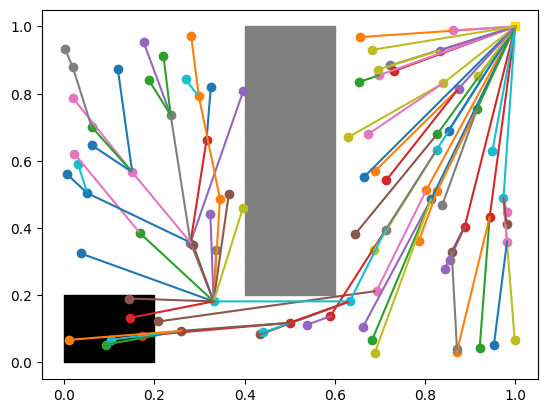

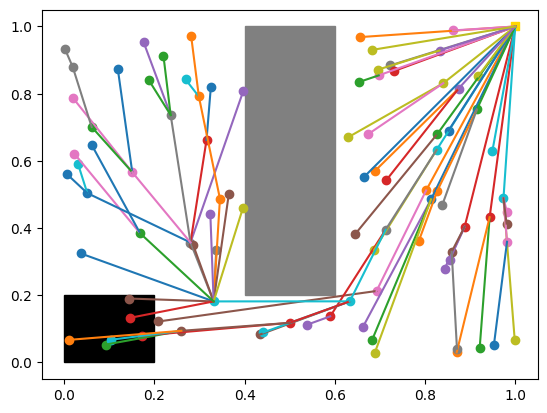

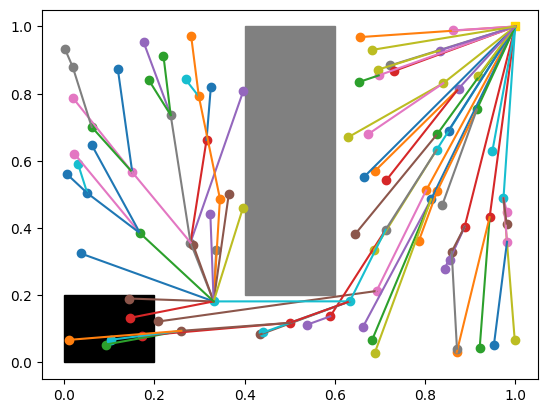

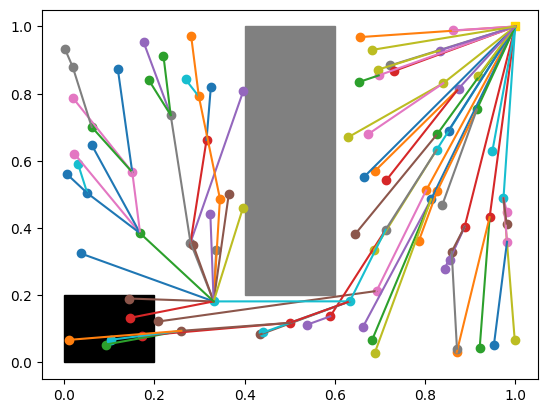

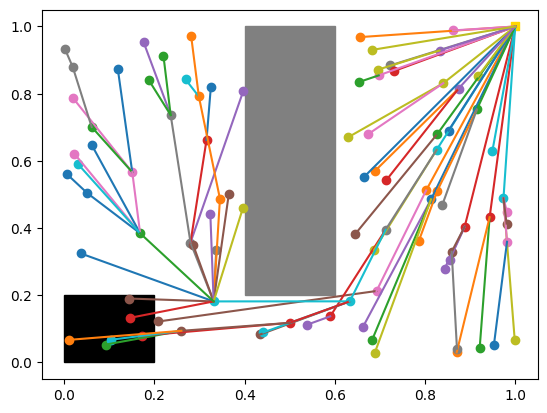

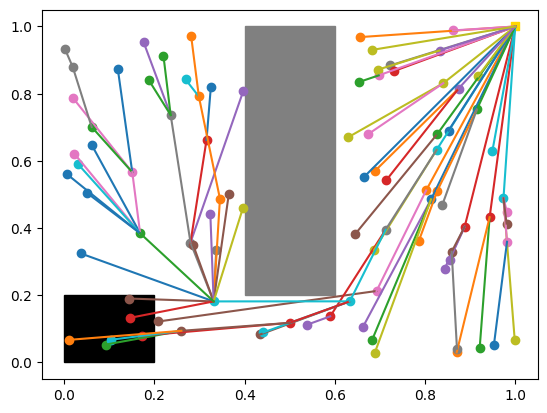

In [2456]:
path, val, Tree_arr = RRTStar(x0, t0, count, obstacles, X_goal, dimension, center, side, eta, m, M, opt_const, n, True)

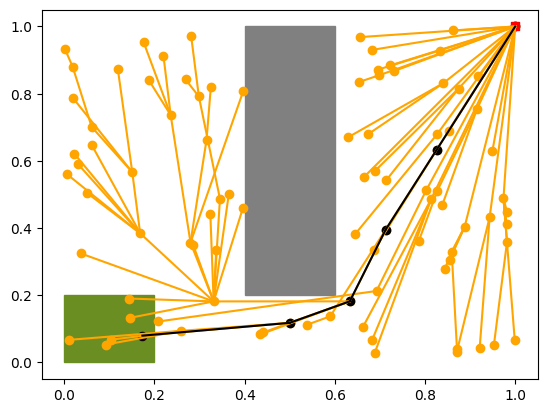

In [2457]:
drawResultsOfAlgorithm(obstacles, X_goal, Tree_arr, path)

In [2458]:
# Ввод препятствий
obstacles = ObstaclesInput()
n = 100

Число препятствий
3
Число вершин 0-го многоугольника
4
0.4 0
0.6 0
0.4 0.2
0.6 0.2
Число вершин 1-го многоугольника
4
0.4 0.4
0.4 0.6
0.6 0.4
0.6 0.6
Число вершин 2-го многоугольника
4
0.4 1
0.6 1
0.4 0.8
0.6 0.8


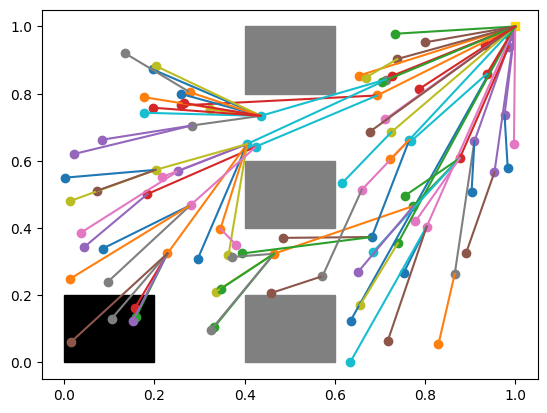

In [2460]:
path, val, Tree_arr = RRTStar(x0, t0, count, obstacles, X_goal, dimension, center, side, eta, m, M, opt_const, n, True)

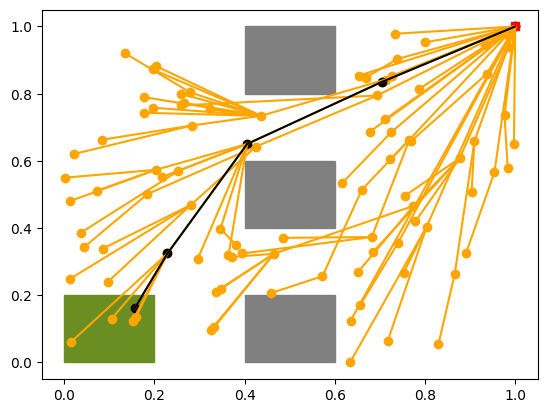

In [2461]:
drawResultsOfAlgorithm(obstacles, X_goal, Tree_arr, path)

In [2462]:
def RRTStar(A, B, C, R, Q, S, T_max, x0, xT, t0, count, obstacles, X_goal, dimension, center, side, eta, m, M, opt_const, n, visualization=False):
    
    ###################################################################################################
    if visualization:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1) 
        
        center = X_goal[0][0]
        goal_coords = X_goal[0][1]
        #Добавляю полярный центр X_goal к множеству точек этой области
        goal_coords = np.append(goal_coords, center.reshape(1, -1), 0)
        ax.fill(goal_coords[:, 0], goal_coords[:, 1], color="black")
        
        for i in range(len(obstacles)):
            obstacle_center = obstacles[i][0]
            obstacle_coords = obstacles[i][1]
            obstacle_coords = np.append(obstacle_coords, obstacle_center.reshape(1, -1), 0)

            ax.fill(obstacle_coords[:, 0], obstacle_coords[:, 1], color="grey")
        
        ax.scatter(x0[0], x0[1], color="gold", marker="s")     
    ###################################################################################################
    
    nodes = x0[:2].reshape(1, -1)
    Tree = Node(t0, x0[:2], 0, 0, ())
    Tree_arr = [Tree]
    for i in range(n):
        x_rand = random_hypercube(dimension, center, side, obstacles)
        x_nearest = Nearest(x_rand, nodes)
        x_new = closerPoint(x_rand, x_nearest, eta)

        idx_nearest = nodeIdx(x_nearest, nodes)
        #x, u, T, t, val, corputIdx = EasySteer(x_nearest, x_new)
        x, u, T, t, val, corputIdx = Steer(A, B, C, R, Q, S, x_nearest, x_new, Tree_arr[idx_nearest].t0, Tree_arr[idx_nearest].t0+T_max, count)
        if np.size(x) and SpaceCheck(x, center, side, corputIdx) \
        and not pathCollisionTest(obstacles, x, corputIdx) and controlCheck(t, u, m, M, corputIdx):
            
            #
            x_new = x[-1, :]
            
            X_near = Near(x_new, nodes, opt_const, eta)                  
            #nodes = np.append(nodes, x_new.reshape(1, -1), axis=0)

            x_min, c_min = x_nearest, Tree_arr[idx_nearest].c + val
            x_best, u_best, t_best, val_best, idx_best = x, u, t, val, idx_nearest          
            for x_near in X_near:
                idx_near = nodeIdx(x_near, nodes)
                #x, u, T, t, val, corputIdx = EasySteer(x_near, x_new)
                x, u, T, t, val, corputIdx = Steer(A, B, C, R, Q, S, x_near, x_new, Tree_arr[idx_near].t0, Tree_arr[idx_near].t0+T_max, count)
                if np.size(x) and (np.linalg.norm(x[-1, :] - x_new) <= 1e-5) and SpaceCheck(x, center, side, corputIdx) and \
                not pathCollisionTest(obstacles, x, corputIdx) and controlCheck(t, u, m, M, corputIdx) and \
                Tree_arr[idx_near].c + val < c_min:
                    x_min, c_min = x_near, Tree_arr[idx_near].c + val
                    x_best, u_best, t_best, val_best, idx_best = x, u, t, val, idx_near 

            #x_new = x_best[-1, :]
            nodes = np.append(nodes, x_new.reshape(1, -1), axis=0)
            node = Node(0, x_new, c_min, nodes.shape[0]-1, (x_best,u_best,t_best,val_best,corputIdx),parent=Tree_arr[idx_best])
            node.parent.childs.append(node)
            Tree_arr.append(node)

            ##############################################################################################
            if visualization:
                x = Tree_arr[-1].E[0][:, 0]
                y = Tree_arr[-1].E[0][:, 1]
                ax.plot(x, y)
                ax.scatter(nodes[-1, 0], nodes[-1, 1])
                display(fig)    
                clear_output(wait = True)
                plt.pause(0.01)
            #############################################################################################

            
            for x_near in X_near:
                idx_near = nodeIdx(x_near, nodes)
                #x, u, T, t, val, corputIdx = EasySteer(x_new, x_near)
                x, u, T, t, val, corputIdx = Steer(A, B, C, R, Q, S, x_new, x_near, Tree_arr[idx_near].t0, Tree_arr[idx_near].t0+T_max, count)
                if np.size(x) and (np.linalg.norm(x[-1, :] - x_near) <= 1e-5) and \
                SpaceCheck(x, center, side, corputIdx) and \
                not pathCollisionTest(obstacles, x, corputIdx) and \
                controlCheck(t, u, m, M, corputIdx) and Tree_arr[-1].c + val < Tree_arr[idx_near].c:
                    Tree_arr[idx_near].E = (x, u, t, val, corputIdx)
                    Tree_arr[idx_near].val = x[-1, :]
                    Tree_arr[idx_near].parent = Tree_arr[-1]
                    childsParamChanger(Tree_arr[idx_near])

                    #########################################################################################
                    if visualization:
                        x = Tree_arr[idx_near].E[0][:, 0]
                        y = Tree_arr[idx_near].E[0][:, 1]
                        ax.lines[idx_near-1].set_data(x, y)
                        display(fig) 
                        plt.pause(0.01)
                    #########################################################################################
            

    best_path, best_val = goalPath(X_goal[0], Tree_arr)
    
    return best_path, best_val, Tree_arr

In [2463]:
# Параметры системы
A = np.array([[10, -10], [-25, 15]])
B = np.array([[12, -3], [-11, 10]])
C = np.array([[0], [0]]).reshape(2, )
R = np.array([[1, 0], [0, 1]])
Q = np.array([[1, 0], [0, 1]])
S = np.array([[1, 0], [0, 1]])
x0 = np.array([1, 1])
t0 = 0
T_max = 0.1
count = 10001

In [2464]:
# Параметры пространства
dimension, center, side = (2, np.array([0, 0]), 1)

In [2465]:
# Параметры ограничений на управление 
m = lambda t: np.array([0, 0])
M = lambda t: np.array([[1, 0], [0, 1]])

In [2466]:
# Параметры для радиуса соединения с ближайшими (при поиске X_near)
eta = 2
V_space = side**dimension
V_unit_sphere = np.pi**(dimension/2) / gamma(dimension/2 + 1)
opt_const = 2 * ((1 + 1/dimension) * V_space / V_unit_sphere) ** (1/dimension)

In [2468]:
obstacles = ObstaclesInput()

Число препятствий
1
Число вершин 0-го многоугольника
4
0.4 0.4
0.6 0.4
0.4 0.6
0.6 0.6


In [2471]:
n = 1000

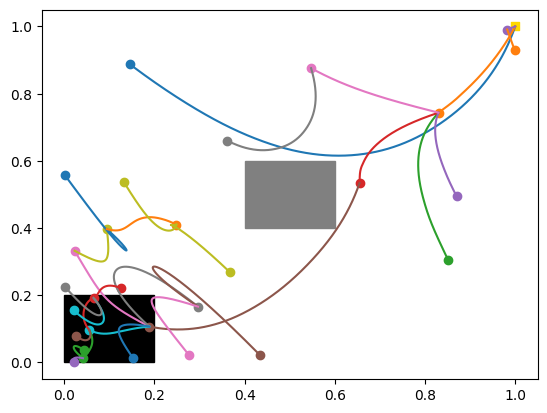

In [2472]:
path, val, Tree_arr = RRTStar(A, B, C, R, Q, S, T_max, x0, xT, t0, count, obstacles, X_goal, dimension, center, side, eta, m, M, opt_const, n, True)

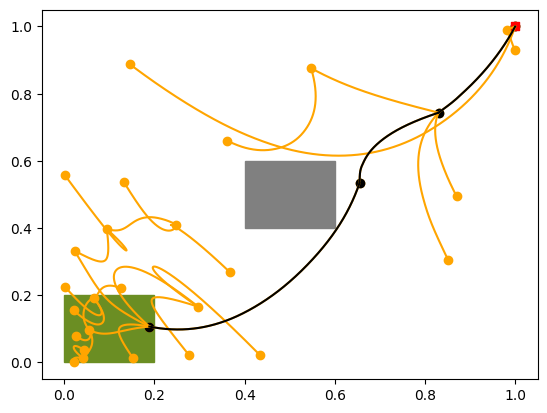

In [2473]:
drawResultsOfAlgorithm(obstacles, X_goal, Tree_arr, path)

In [2476]:
def RRTStar(A, B, C, R, Q, S, T_max, x0, t0, count, obstacles, X_goal, dimension, center, side, eta, m, M, opt_const, n, visualization=False):
    
    ###################################################################################################
    if visualization:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1) 
        
        center = X_goal[0][0]
        goal_coords = X_goal[0][1]
        #Добавляю полярный центр X_goal к множеству точек этой области
        goal_coords = np.append(goal_coords, center.reshape(1, -1), 0)
        ax.fill(goal_coords[:, 0], goal_coords[:, 1], color="black")
        
        for i in range(len(obstacles)):
            obstacle_center = obstacles[i][0]
            obstacle_coords = obstacles[i][1]
            obstacle_coords = np.append(obstacle_coords, obstacle_center.reshape(1, -1), 0)

            ax.fill(obstacle_coords[:, 0], obstacle_coords[:, 1], color="grey")
        
        ax.scatter(x0[0], x0[1], color="gold", marker="s")     
    ###################################################################################################
    
    nodes = x0[:2].reshape(1, -1)
    Tree = Node(t0, x0[:2], 0, 0, ())
    Tree_arr = [Tree]
    for i in range(n):
        x_rand = random_hypercube(dimension, center, side, obstacles)
        x_nearest = Nearest(x_rand, nodes)
        #x_new = closerPoint(x_rand, x_nearest, eta)

        idx_nearest = nodeIdx(x_nearest, nodes)
        l0 = x_nearest - x0 + np.random.rand(2, ) * 0.01
        l0 = np.array([-l0[1], l0[0]]) / np.linalg.norm(l0)
        X = X_search(A.shape[0], A, B, M, l0, Tree_arr[idx_nearest].t0, Tree_arr[idx_nearest].t0 + T_max)       
        q = q_search(A, B, C, m, x_nearest, Tree_arr[idx_nearest].t0, Tree_arr[idx_nearest].t0 + T_max)
        q = q.reshape(A.shape[0], )
        x_new = random_ellipsoid(dimension, q, X, obstacles)
        x_new = closerPoint(x_new, x_nearest, eta)

        #x, u, T, t, val, corputIdx = EasySteer(x_nearest, x_new)
        x, u, T, t, val, corputIdx = Steer(A, B, C, R, Q, S, x_nearest, x_new, Tree_arr[idx_nearest].t0, Tree_arr[idx_nearest].t0+T_max, count)
        if np.size(x) and SpaceCheck(x, center, side, corputIdx) \
        and not pathCollisionTest(obstacles, x, corputIdx) and controlCheck(t, u, m, M, corputIdx):
            
            #
            x_new = x[-1, :]
            
            X_near = Near(x_new, nodes, opt_const, eta)                  
            #nodes = np.append(nodes, x_new.reshape(1, -1), axis=0)

            x_min, c_min = x_nearest, Tree_arr[idx_nearest].c + val
            x_best, u_best, t_best, val_best, idx_best = x, u, t, val, idx_nearest          
            for x_near in X_near:
                idx_near = nodeIdx(x_near, nodes)
                #x, u, T, t, val, corputIdx = EasySteer(x_near, x_new)
                x, u, T, t, val, corputIdx = Steer(A, B, C, R, Q, S, x_near, x_new, Tree_arr[idx_near].t0, Tree_arr[idx_near].t0+T_max, count)
                if np.size(x) and (np.linalg.norm(x[-1, :] - x_new) <= 1e-5) and SpaceCheck(x, center, side, corputIdx) and \
                not pathCollisionTest(obstacles, x, corputIdx) and controlCheck(t, u, m, M, corputIdx) and \
                Tree_arr[idx_near].c + val < c_min:
                    x_min, c_min = x_near, Tree_arr[idx_near].c + val
                    x_best, u_best, t_best, val_best, idx_best = x, u, t, val, idx_near 

            x_new = x_best[-1, :]
            nodes = np.append(nodes, x_new.reshape(1, -1), axis=0)
            node = Node(0, x_new, c_min, nodes.shape[0]-1, (x_best,u_best,t_best,val_best,corputIdx),parent=Tree_arr[idx_best])
            node.parent.childs.append(node)
            Tree_arr.append(node)

            ##############################################################################################
            if visualization:
                x = Tree_arr[-1].E[0][:, 0]
                y = Tree_arr[-1].E[0][:, 1]
                ax.plot(x, y)
                ax.scatter(nodes[-1, 0], nodes[-1, 1])
                display(fig)    
                clear_output(wait = True)
                plt.pause(0.01)
                
                #a = np.arange(0, 2*np.pi, 0.1)
                #x = np.cos(a)
                #y = np.sin(a)
                #for i in range(len(x)):
                #    l = np.array([x[i], y[i]])
                #    z = np.dot(q, l) + X@l / np.sqrt(l.T@X@l)
                #    plt.scatter(z[0], z[1])
                    
                #plt.pause(5)
            #############################################################################################

            for x_near in X_near:
                idx_near = nodeIdx(x_near, nodes)
                #x, u, T, t, val, corputIdx = EasySteer(x_new, x_near)
                x, u, T, t, val, corputIdx = Steer(A, B, C, R, Q, S, x_new, x_near, Tree_arr[idx_near].t0, Tree_arr[idx_near].t0+T_max, count)
                if np.size(x) and (np.linalg.norm(x[-1, :] - x_near) <= 1e-5) and \
                SpaceCheck(x, center, side, corputIdx) and not pathCollisionTest(obstacles, x, corputIdx) and \
                controlCheck(t, u, m, M, corputIdx) and Tree_arr[-1].c + val < Tree_arr[idx_near].c:
                    Tree_arr[idx_near].E = (x, u, t, val, corputIdx)
                    Tree_arr[idx_near].val = x[-1, :]
                    Tree_arr[idx_near].parent = Tree_arr[-1]
                    childsParamChanger(Tree_arr[idx_near])

                    #########################################################################################
                    if visualization:
                        x = Tree_arr[idx_near].E[0][:, 0]
                        y = Tree_arr[idx_near].E[0][:, 1]
                        ax.lines[idx_near-1].set_data(x, y)
                        display(fig) 
                        plt.pause(0.01)
                    #########################################################################################

    best_path, best_val = goalPath(X_goal[0], Tree_arr)
    
    return best_path, best_val, Tree_arr

In [2490]:
n = 1000

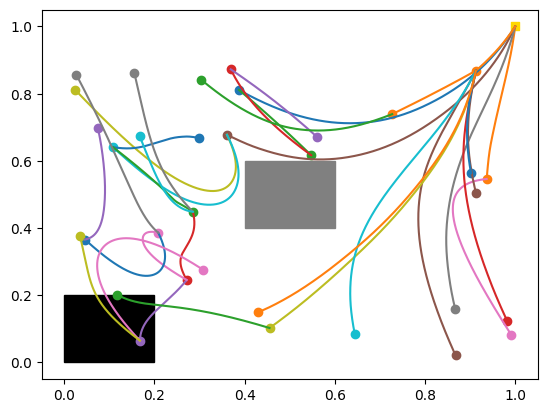

In [2488]:
path, val, Tree_arr = RRTStar(A, B, C, R, Q, S, T_max, x0, t0, count, obstacles, X_goal, dimension, center, side, eta, m, M, opt_const, n, True)

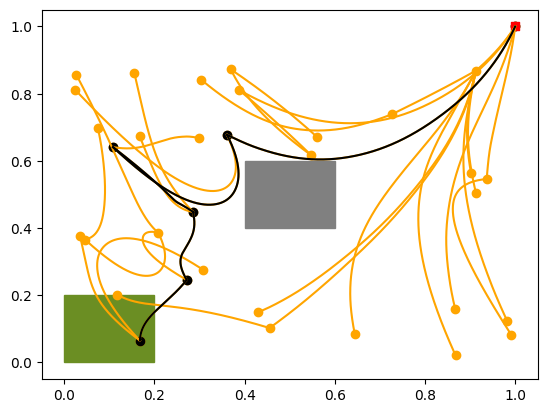

In [2489]:
drawResultsOfAlgorithm(obstacles, X_goal, Tree_arr, path)